In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.primitives import StatevectorEstimator as Estimator

# algorithm_globals.random_seed = 42

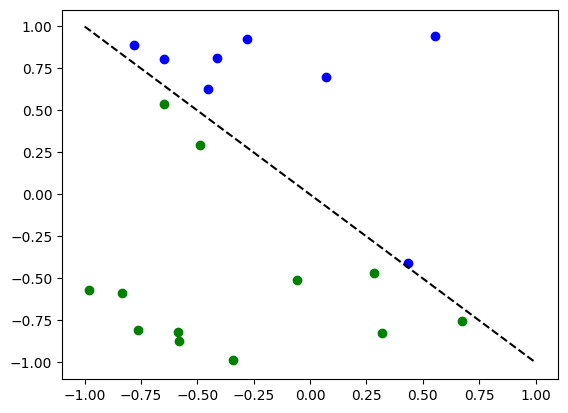

In [2]:
num_inputs = 2
num_samples = 20
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1 # Generate random data - points on a grid
y01 = 1 * (np.sum(X, axis=1) >= 0) # Generate labels - separate points on y = -x
y = 2 * y01 - 1 # Map labels to {-1, 1}
y_one_hot = np.zeros((num_samples, 2)) # Turn labels (0 or 1) into vectors 0 -> [1, 0] and 1 -> [0, 1]
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()
# Points above the line are labeled 1, points below the line are labeled -1

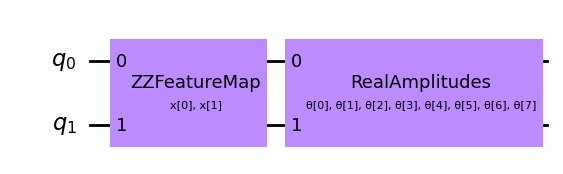

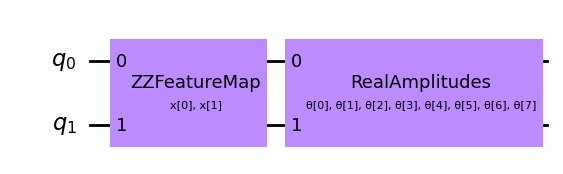

In [3]:
# Construct QNN QNNCircuit - defaults to ZZFeatureMap and RealAmplitudes ansatz
qc = QNNCircuit(2)
qc.draw("mpl",style="clifford")

In [4]:
# Each point has two bits, [x1, x2], and a corresponding label y.
# We encode the points using angle embedding, manipulate the state in quantum space, and measure the state in Z.
# Blue points (1) should be mapped to |0> and green points (-1) should be mapped to |1>.

# Note -- try different feature map and ansatz.
# Why are they using ZZFeatureMap if all this data is independent?
# Note -- learn RealAmplitudes ansatz, NeuralNetworkClassifier, callback function, and cross-entropy loss function

estimator = Estimator()
estimator_qnn = EstimatorQNN(circuit=qc, estimator=estimator)

estimator_qnn.forward(X[0, :], algorithm_globals.random.random(estimator_qnn.num_weights)) # Forward pass with random weights

C:\Users\kaisa\AppData\Local\Temp\ipykernel_5088\664408577.py:9: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
C:\Users\kaisa\AppData\Local\Temp\ipykernel_5088\664408577.py:10: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  estimator_qnn = EstimatorQNN(circuit=qc, estimator=estimator)


array([[-0.47188221]])

In [5]:
# construct neural network classifier
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=60)
)

# fit classifier to data
estimator_classifier.fit(X, y)

# score classifier
estimator_classifier.score(X, y)

0.65

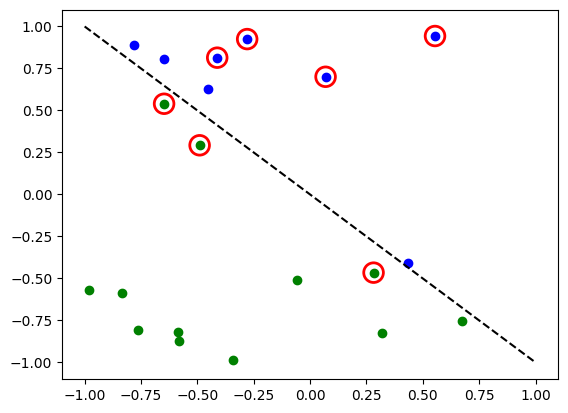

In [6]:
# evaluate data points
y_predict = estimator_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

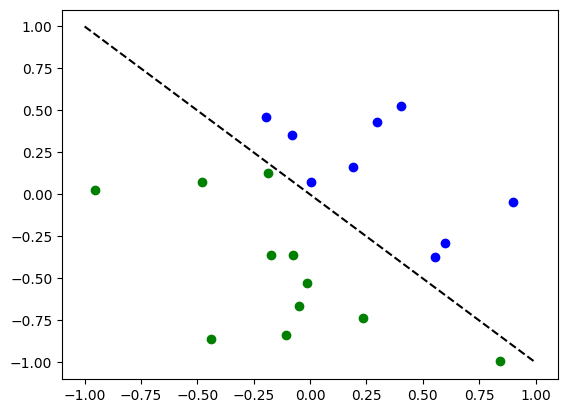

In [7]:
# Generate test data
X_test = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1 # Generate random data - points on a grid
y01_test = 1 * (np.sum(X_test, axis=1) >= 0) # Generate labels - separate points on y = -x
y_test = 2 * y01_test - 1 # Map labels to {-1, 1}
y_one_hot_test = np.zeros((num_samples, 2)) # Turn labels (0 or 1) into vectors 0 -> [1, 0] and 1 -> [0, 1]
for i in range(num_samples):
    y_one_hot[i, y01_test[i]] = 1

for x, y_target in zip(X_test, y_test):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
plt.plot([-1, 1], [1, -1], '--', color='black')
plt.show()

0.75


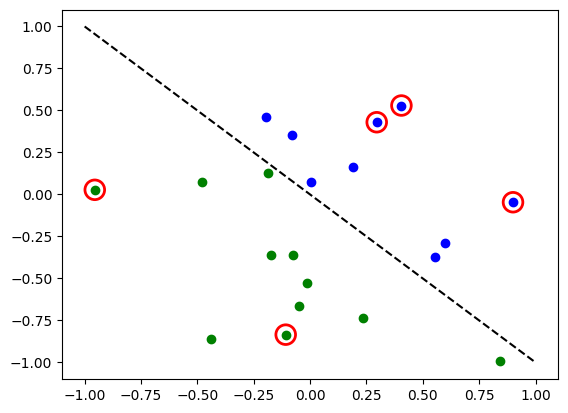

In [8]:
# Test and plot results
print(estimator_classifier.score(X_test, y_test))
# evaluate data points
y_predict = estimator_classifier.predict(X_test)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X_test, y_test, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()